<a href="https://colab.research.google.com/github/mkorlyakova/MSTU-courses/blob/main/ML%20magister/6/ML_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Лабораторная работа 3

## Машины Опорных векторов


**цель работы:**
  
  - отработка поиска гиперпараметров моделей методом сеточного перебора
  - отработка настройки алгоритмов генерации оптимальных линейных границ между классами
  - отработка применения препроцессинга данных для линейных моделей

#Машины Опорных векторов



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

## Support Vector Machine

_Метод опорных векторов_ (англ. SVM, support vector machine) - частный случай линейного классификатора. Особым свойством метода опорных векторов является непрерывное уменьшение эмпирической ошибки классификации и увеличение зазора, поэтому метод также известен как метод классификатора с максимальным зазором.

Ключом к успеху этого классификатора является то, что для подбора имеет значение только положение опорных векторов; любые точки дальше от поля, которые находятся на правильной стороне, не изменяют посадку! Технически это связано с тем, что эти точки не вносят вклад в функцию потерь, используемую для подбора модели, поэтому их положение и количество не имеют значения, пока они не пересекают границу

### Рабочая часть модели


Точки имеют вид:
    T=(x⃗i,yi) i=1,l
    
    Y={−1,+1}

### Разделяющая гиперплоскость
В пространстве Rn уравнение ⟨w⃗ ,x⃗ ⟩−b=0 при заданных w⃗  и b определяет гиперплоскость — множество векторов x⃗ =(x1,…,xn), принадлежащих пространству меньшей размерности Rn−1.

Параметр w⃗  определяет вектор нормали к гиперплоскости, а через b/∥w⃗ ∥ выражается расстояние от гиперплоскости до начала координат.

Гиперплоскость делит Rn на два полупространства:
      
      ⟨w⃗ ,x⃗ ⟩−b>0 и ⟨w⃗ ,x⃗ ⟩−b<0

### **Линейно разделимая выборка**

Пусть выборка линейно разделима, то есть существует некоторая гиперплоскость, разделяющая классы −1 и +1. Тогда в качестве алгоритма классификации можно использовать линейный пороговый классификатор:

a(x⃗ )=sign(⟨w⃗ ,x⃗ ⟩−b)=sign(∑wixi−b), i = 1,l

где x⃗ =(x1,…,xn) — вектор значений признаков объекта, а w⃗ =(w1,…,wn)∈Rn и b∈R — параметры гиперплоскости.



Отступ ( margin) — характеристика x⃗, оценивающая насколько типичным представителем класса он является. Чем меньше значение отступа M, тем ближе объект x⃗ подходит к границе классов и тем выше становится вероятность ошибки.

Отступ M отрицателен тогда и только тогда, когда алгоритм a(x) допускает ошибку на объекте x⃗.

Для линейного классификатора отступ определяется уравнением: Mi(w⃗ ,b)=yi(⟨w⃗ ,x⃗i⟩−b) для объекта x⃗i


### Потери

задачи оптимизации в терминах квадратичного программирования:

L(w, x, y) = lambda||w||^2 + sum( max(0, 1-y_i < w, x_i>))


In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# для красивых картинок
import seaborn as sns; sns.set()

В качестве примера рассмотрим простой случай задачи классификации, в которой два класса точек хорошо разделены:

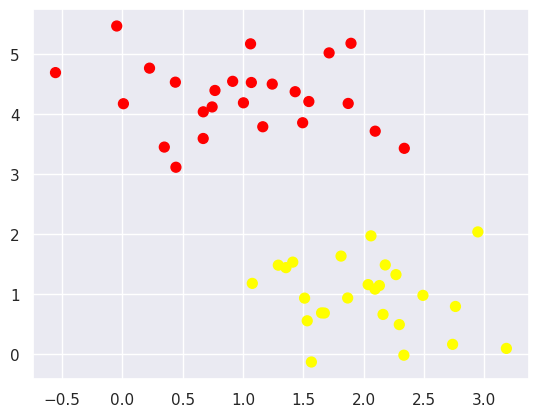

In [3]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Линейный дискриминационный классификатор попытается провести прямую линию, разделяющую два набора данных, и тем самым создать модель для классификации. Но сразу же видим проблему: существует более одной возможной разделительной линии, которая может идеально различить два класса

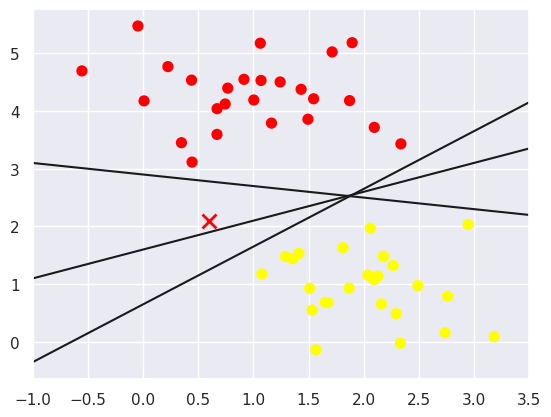

In [4]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

Машины опорных векторов предлагают один из способов улучшить это. Интуиция : вместо того, чтобы просто рисовать линию нулевой ширины между классами, мы можем нарисовать вокруг каждой линии отступ некоторой ширины вплоть до ближайшей точки. Вот пример того, как это может выглядеть:

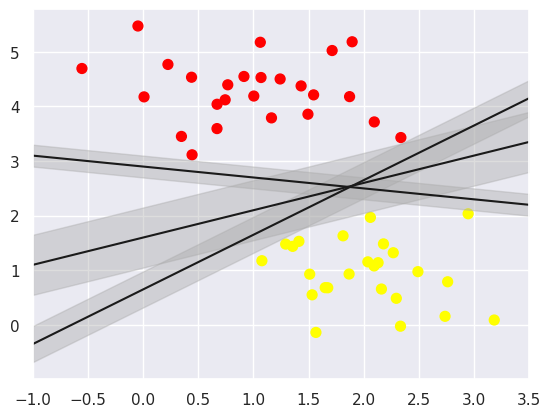

In [5]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

В машинах опорных векторов линия, которая максимизирует этот зазор, будет той, которую мы выберем в качестве оптимальной модели. Машины опорных векторов являются примером такой оценки максимальной ширины зазора

Будем использовать классификатор опорных векторов Scikit-Learn для обучения модели SVM.

class sklearn.svm.SVC(*, C=1.0, kernel='rbf', degree=3, gamma='scale', coef0=0.0, shrinking=True, probability=False, tol=0.001, cache_size=200, class_weight=None, verbose=False, max_iter=-1, decision_function_shape='ovr', break_ties=False, random_state=None)

https://scikit-learn.org/stable/modules/svm.html#svm-classification


  - C :  по умолчанию = 1., Параметр регуляризации. Сила регуляризации обратно пропорциональна C. Должна быть строго положительной. Штраф представляет собой штраф в квадрате l2.

  - kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} или вызываемое, по умолчанию = 'rbf'. Указывает тип ядра, который будет использоваться в алгоритме. Если ничего не указано, будет использоваться 'rbf'.

  - degree, по умолчанию = 3
Степень полиномиальной функции ядра ('poly'). Игнорируется всеми другими ядрами.

  - gamma: {'scale', 'auto'} или с плавающей запятой, по умолчанию = 'sacle'
Коэффициент ядра для «rbf», «poly» и «sigmoid».(если gamma='scale'передается (по умолчанию), то в качестве значения гаммы используется 1 / (n_features * X.var()), если «auto», использует 1 / n_features.

  - coef0 : по умолчанию = 0,0 Независимый член в функции ядра. Это имеет значение только в 'poly' и 'sigmoid'.


  - tol: критерий останова по изменению значений, по умолчанию = 1e-3

  - max_iter:   по умолчанию=-1. Жесткий лимит итераций в решателе или -1 без ограничений.
  
  - class_weightdict or ‘balanced’, default=None: балансированные или нет классы, если нет то передать словарь с {имя класса:вес класса}

  - decision_function_shape: {'ovo', 'ovr'}, по умолчанию = 'ovr': решения «один против остальных» («ovr») формы (n_samples, n_classes) или исходную функцию решения «один против одного» («ovo») libsvm, которая имеет форму (n_samples , n_classes * (n_classes - 1)/2).  (Однако обратите внимание, внутренне всегда используется метод «один против одного» , а второй вариант пересчитывается из него ).


Возвращаемые атрибуты:

  - coef_ - коэффициенты для линейного ядра
  - n_support_ - количество опорных векторов
  - support_vectors_ - опорные векторы
  - support_ndarray  - индексы опорныйх векторов


Используем линейное ядро ​​и установим для C параметра очень большое число

In [6]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, kernel='linear')

Отобразим результат:

In [7]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # сетка примеров для оценки значений в точках пространства
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)

    # отрисуем поля и гиперплоскость (по уровням -1, 0, 1)
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])

    # отрисуем опорные вектора
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=100, linewidth=6, facecolors='g', alpha=0.3)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

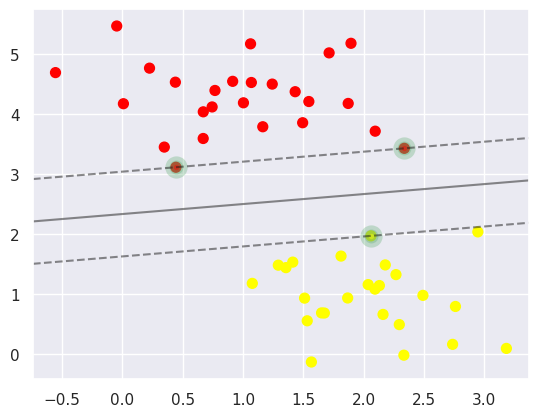

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Обратите внимание, что несколько точек обучения просто касаются поля: на этом рисунке они обозначены черными кружками. Эти точки являются ключевыми элементами этой подгонки и известны как опорные векторы и дают название алгоритму. В Scikit-Learn идентификаторы этих точек хранятся в support_vectors_:

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

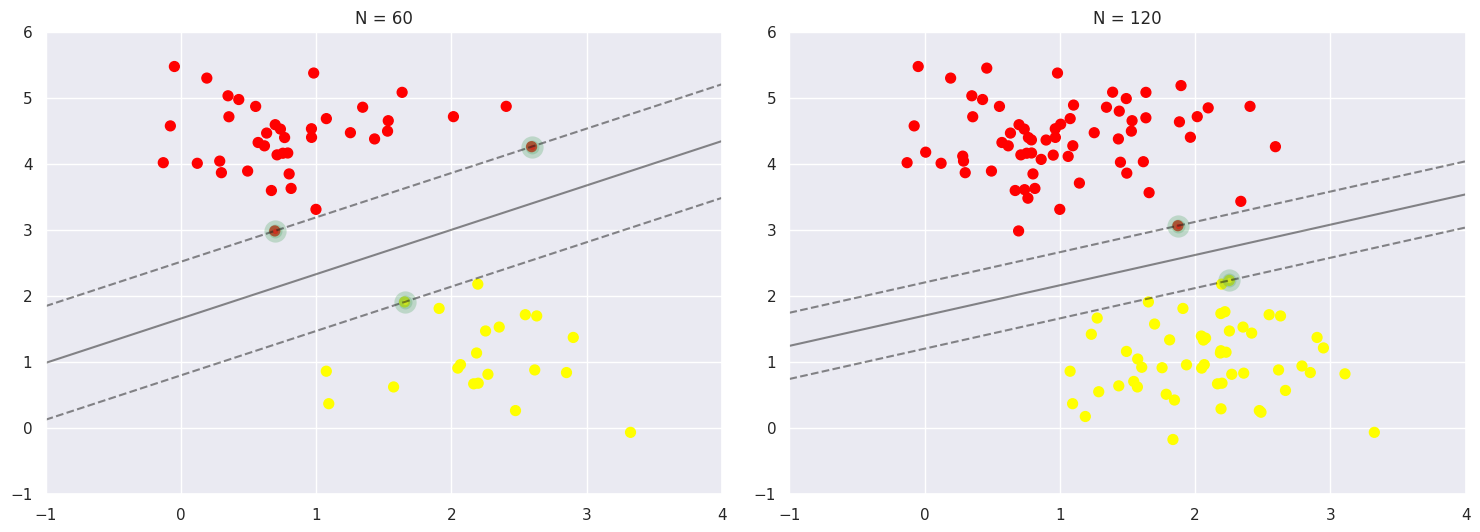

In [10]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=500, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)

    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)
    return model

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

На левом рисунке модель и опорные векторы для 60 обучающих точек. На правом рисунке 120 точек обучения, но модель не изменилась: три опорных вектора с левой панели по-прежнему являются опорными векторами с правой панели. Эта нечувствительность к точному поведению удаленных точек является одной из сильных сторон модели SVM.

interactive(children=(Dropdown(description='N', options=(10, 100, 200, 500), value=10), Output()), _dom_classe…

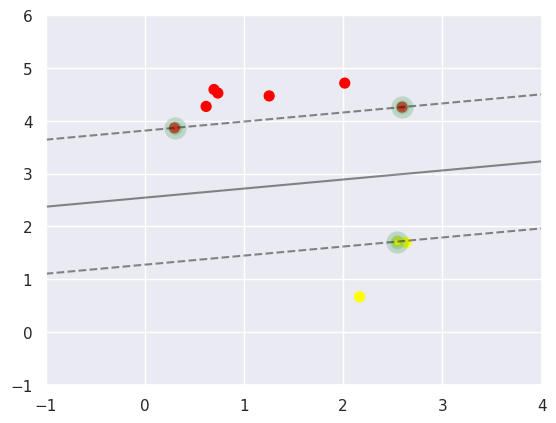

In [11]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10,100, 200, 500], ax=fixed(None));

### **Задание 1.**

1.1 Оцените визуально изменение положения гиперплоскости для числа точек в обучении N(k) в диапазоне от 10 до 500 в текущем примере для к = 1,5 .

1.2 Оцените изменение параметров гиперплоскости после нормализации (coef = coef_ / np.sum(( m1.coef_ ) ** 2) ** 0.5) используем (coef) в форме |coef(к) - coef(к-1)|/coef(k) для разных подмножеств примеров N(k)


1.3  зафиксируйте результаты в таблице и сделайте выводы

[[ 0.32251964 -0.94656277]]
[[ 0.37146909 -0.92844532]]


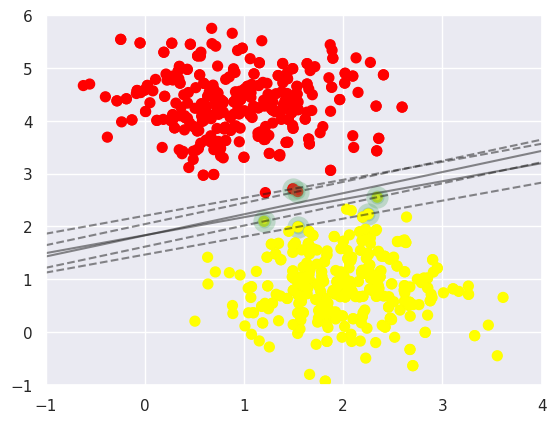

In [12]:
for  N in [ 200, 500]:
    m1  = plot_svm(N)
    m1.predict([[0,0],[2,2]])
    print(m1.coef_/np.sum((m1.coef_)**2)**0.5)

SVM становится чрезвычайно мощным в сочетании с ядрами . Можно спроецировать данные в многомерное пространство, определяемое полиномами и базисными функциями Гаусса, и, таким образом, из нелинейных ппредставлений перейти к линеаризированным.

В моделях SVM для данных, которые не являются линейно разделимыми используем ядра одного из нелинейных типов:

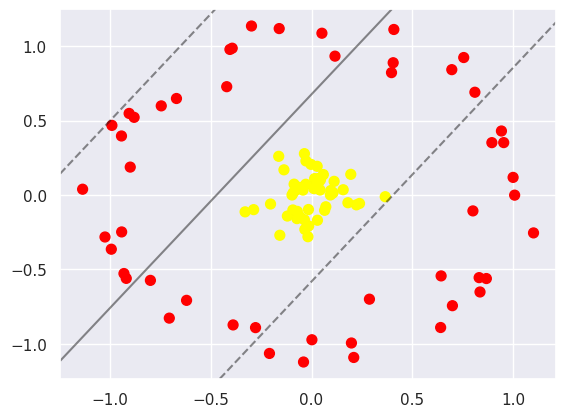

In [13]:
from sklearn.datasets import make_circles
X, y = make_circles(100, factor=0.1, noise=0.1) # строим не линейное пространство примеров

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

Линейная модель не работает. Построим ядро для преобразования:

In [14]:
r = np.exp(-(X ** 2).sum(1))  # радиально-базисная -функция

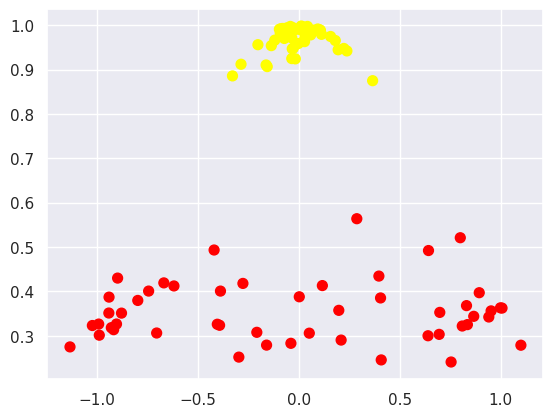

In [15]:
# проекция
plt.scatter(X[:, 0], r, c=y, s=50, cmap='autumn')
plt.show()

Получили пространство, где классы вполне разделимы.


С дополнительным измерением данные становятся тривиально линейно разделимыми, рисуя разделяющую плоскость, скажем, при r = 0,7.

Однако такую проекцию нужно построить. Нужно центрировать радиальную базисную функцию в правильном месте,иначе не будет таких чистых, линейно разделимых результатов. Такой выбор — проблема.

Одна из стратегий состоит в том, чтобы вычислить базисную функцию с центром в каждой точке набора данных и позволить алгоритму SVM просеивать результаты. Этот тип преобразования базисной функции известен как преобразование ядра , поскольку оно основано на отношении подобия (или ядре) между каждой парой точек.

Потенциальная проблема с этой стратегией — проецирование Н указывает на Н размеры — это то, что он может стать очень ресурсоемким, поскольку Н вырастает большим. Используем трюк с ядром для ускорения процесса: подгонка данных, преобразованных ядром, может быть выполнена неявно, т. е. даже без построения полной Н -мерное представление проекции ядра! Этот трюк с ядром встроен в SVM и является одной из причин, по которой этот метод настолько эффективен.

В Scikit-Learn мы можем применить ядерную SVM, просто изменив наше линейное ядро ​​на ядро ​​RBF (радиальная базисная функция), используя kernel гиперпараметр модели. Включаем радиальное ядро:

In [16]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0)

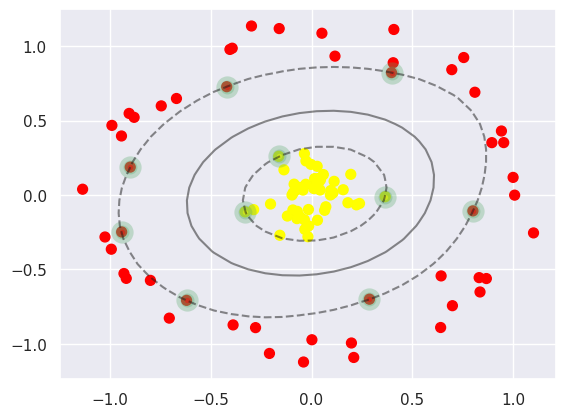

In [17]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

### **Задание 2.**

1.1  Проведите эксперимент с изменением типа ядра (линейные, не линейные ядра) для примера из :
  - make_circles(100, factor=0.1, noise=0.1),
  - make_circles(100, factor=0.5, noise=0.1),
  - make_circles(100, factor=0.1, noise=0.2),
  - make_circles(1000, factor=0.1, noise=0.1)
  
  и оцените число опорных векторов.

1.2  зафиксируйте результаты в таблице и сделайте выводы


## Настройка SVM: смягчение границ
Для очень чистых наборов данных, в которых существует идеальная граница решения можно работать без проблем. Однако множества данных, чаще всего, сильно пересекаются, Например, так:

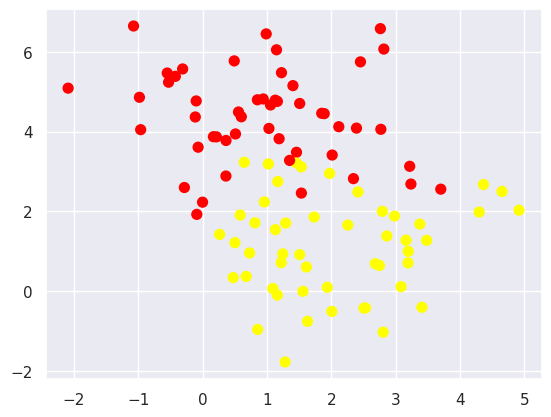

In [18]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Чтобы справиться с этим, в реализации SVM есть некоторый фактор, который «смягчает» поля: то есть он позволяет некоторым точкам проникать в зазор. Твердость зазора контролируется параметром настройки, чаще всего известным как С. Для очень больших С зазор является жестким, и точки не могут лежать в нем. Для меньших С,  зазор мягче и может охватывать некоторые точки.

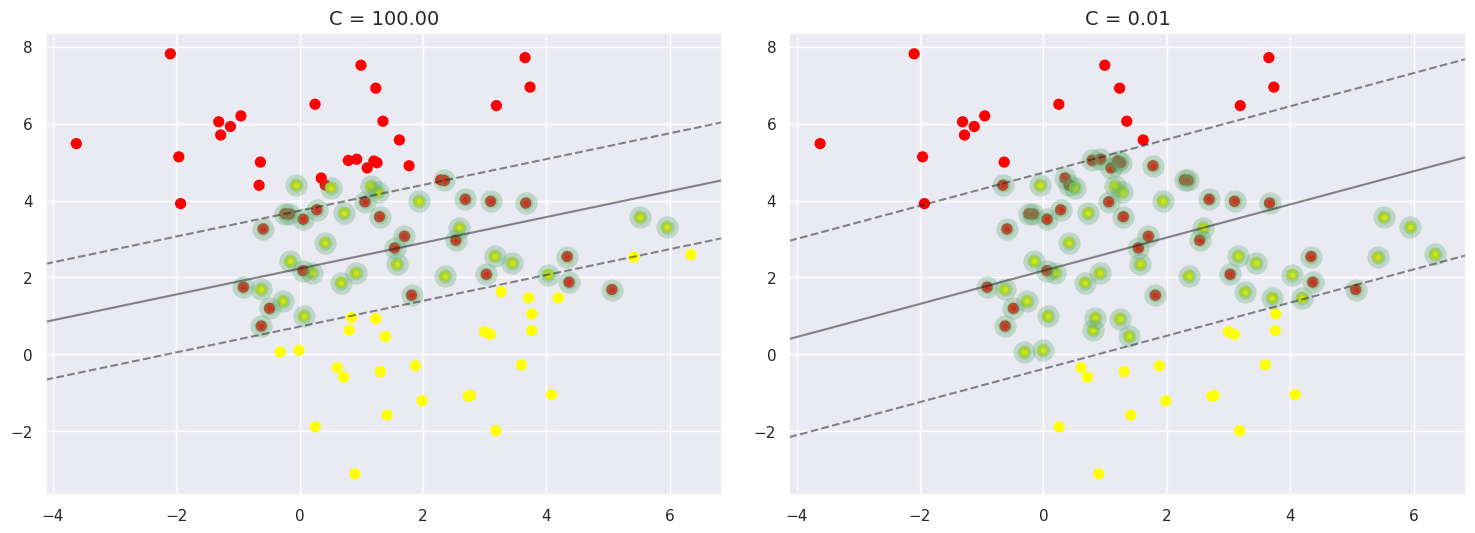

In [35]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [100, 0.01]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.2f}'.format(C), size=14)

### **Задание 3.**

3.1. для вариантов:
  -  make_blobs(n_samples=100, centers=2,random_state=0, cluster_std=0.8)
  -  make_blobs(n_samples=100, centers=2,random_state=0, cluster_std=1.8)
  построить решение с изменением С в диапазоне от 0.1 до 100 (0.01, 1., 10., 100.) и оценить число опорных векторов

3.2. Оцените изменение параметров гиперплоскости после нормализации (coef = coef_ / np.sum(( m1.coef_ ) * * 2 ) ** 0.5) используем (coef) в форме |coef(к) - coef(к-1)|/coef(k) для разных С в обоих вариантах   

### **Задание 4.**

Построить последовательность обработки примеров для набора "Ирисы Фишера"(load_iris):
 4.1. провести генерацию классификатора SVM (по схеме из лекции ) 5 вариантов:
    - изменяем тип ядра
    - параметр С
 4.2. выбрать наиболее эффективное сочетание параметров из полученных моделей по f1_score
 4.3 провести анализ результата (метрики) и сравнить с результатом логистической регрессии

In [39]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report
import sklearn.datasets as datasets

### **Задание 5.**

Самостоятельно оценить данные по варианту:

In [40]:

V1 = datasets.load_wine()
V2 = datasets.load_digits()
V3 = datasets.load_breast_cancer()
V4 = datasets.make_classification(n_samples = 10000, n_features=5, n_redundant=2, n_informative=2,random_state=10, n_clusters_per_class=2)
V5 = datasets.fetch_covtype(return_X_y=True)
V6 = datasets.make_blobs(n_samples=10000, centers=2, n_features=5, random_state=10)
V7 = datasets.make_circles(n_samples=10000, factor=0.5, noise=0.05)
V8 = datasets.make_moons(n_samples=10000, noise=0.05)

Сравнить с результатом логистической регрессии.

 5.1.Загрузить данные  по варианту

 5.2.Построить линейный классификатор в формате sklearn (SVM) .

 5.3. Выбрать метрику (учитываем балансировку данных и смысл задачи) и оценить качество модели на отложенной выборке

 5.4. сделать выводы о качестве для модели на основе выбранной метрики

 5.5. Привести все признаки к одному диапазону (0,1) (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler) или провести стандартизацию признаков (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) , построить модель в sklearn и оценить метрики на отложеной выборке

 5.6. Построить классификатор с изменением основных гиперпараметров (по sklearn) : эксперимент по каждому направлению отдельно : kernel  {'linear', 'poly', 'rbf', 'sigmoid'}, tol = [0.0001, 0.001, 0.01, 0.1], C=[0.1,1.,10,100]. Зафиксировать в каждом эксперименте(при изменении одного из параметров) accuracy, f1,точность, полнота, РR_auc,  ROC_auc в таблице результатов.

 5.7 Сделать выводы о качестве модели

## Пример работы с более сложными данными:

In [41]:
from sklearn.datasets import fetch_lfw_people # изображения лиц людей (медийно известные персоны)
faces = fetch_lfw_people(min_faces_per_person=60)  # берем 60 фотографий на персону
print(faces.target_names)  #  покажем список полученых персон
print(faces.images.shape)  #  размеры данных (картинки 62 на 47 пикселей)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


Визуализируем примеры из набора данных:



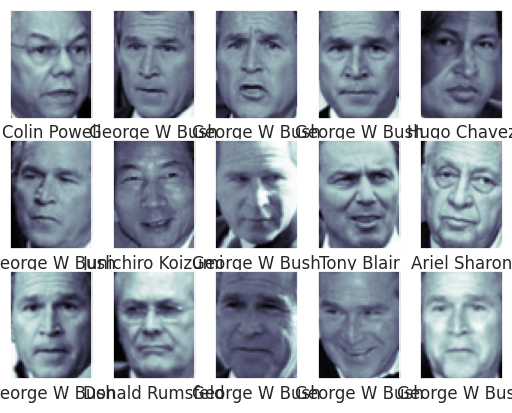

In [42]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Задача представляет 8 классов, т.е. нужно использовать многоклассовую версию  SVM Classifier: SVC c 'ovr'


Каждый пример содержит 62 * 47 пикселей - таким образом исходных ("сырых") признаков очень много. Сделаем стандартную обработку с целью понизить размерность данных (используем РСА преобразование - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html?highlight=pca - его особенности обсудим позднее. Пока важно, что из 62 * 47 признаков получим 150 признаков, что уже подходит для работы в пространстве примеров. где всего 1348 объектов )


Кроме того , используем механизм конвейеров обработки (пайплайны https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html ). Для этого существует специализированный класс Pipeline, который позволяет объединять отдельные этапы обработки данных (преобразования и обучение ) в один общий объект. Этот общий объект можно создавать разными способами. тут используем  функцию make_pipeline, куда передаем созданные объекты преобразования данных и классификатор (pca, svc).

Готовим данные для обучения и теста:

In [63]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

оценим пропорции классов:

In [73]:
dict_class = {i : 1/(np.sum(ytrain == i)/len(ytrain)) for i in set(ytrain)}
dict_class

{0: 16.306451612903224,
 1: 6.017857142857143,
 2: 11.233333333333333,
 3: 2.5024752475247523,
 4: 11.75581395348837,
 5: 19.823529411764707,
 6: 21.0625,
 7: 9.911764705882353}

In [74]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline # сборка конвейера обработки.

# сделаем преобразование РСА
pca = PCA(n_components=150, whiten=True, random_state=42)
# классы не сбалансированны
svc = SVC(kernel='rbf', class_weight=dict_class)
model = make_pipeline(pca, svc) # сборка конвейера обработки. не обучен, но уже собран в один объект и преобразование данных и классификатор

Для поиска хорошей комбинации параметров пользуемся методом перебора всех возможных вариантов из списка. Во всех экспериентах выше использован именно этот подход, но для одного из параметров. Однако наиболее эффективные результаты достигаются в полном переборе всех со всеми - это **сеточный поиск**.

Запустим механизм сеточного поиска для формирования наиболее эффективного набора гиперпараметров алгоритм:
  
  - используем объект GridSearchCV (сеточный поиск https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html?highlight=gridsearchcv#sklearn.model_selection.GridSearchCV)
  - в качестве пространства поиска зададим список параметров:
      - 'svc__C': [0.01, 0.5, 1.0, 50], - жесткость зазора
      - 'svc__gamma': [0.0001, 0.0005, 0.001, 0.005] - коэффициент ядра
  - используем радиальное-ядро


  Итогом работы этого объекта является комбинация параметров (.best_params_) с лучшей оценкой и наиболе качественная модель (.best_estimator_)
  
  Работает не очень быстро!!!     

In [75]:
from sklearn.model_selection import GridSearchCV  # для создания механизма сеточного поиска.
param_grid = {'svc__C': [0.01, 0.5, 1.0, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)  # создаем объект для сеточного поиска.

%time grid.fit(Xtrain, ytrain)  # проводим сеточный поиск лучшей модели по гиперпараметрам
print(grid.best_params_)  # лучшие параметры



CPU times: user 41.6 s, sys: 29.6 s, total: 1min 11s
Wall time: 42.3 s
{'svc__C': 0.5, 'svc__gamma': 0.001}


Проверяем качество на тестовых примерах

In [76]:
model = grid.best_estimator_  # лучшая модель по версии сеточного поиска (уже обучена в процессе сеточного поиска)
yfit = model.predict(Xtest)  # применяем эту модель к нашим тестам


Визуализируем тесты:

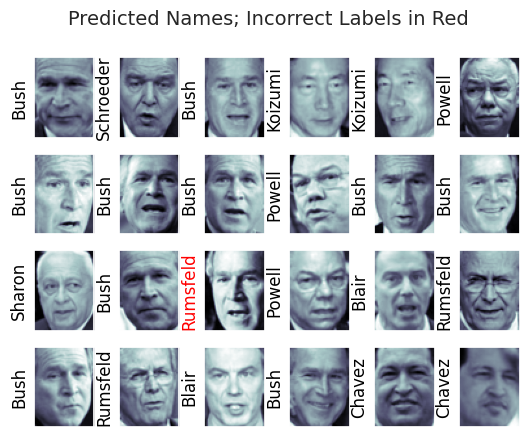

In [77]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

Оцениваем результаы по всем классам:

In [78]:
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.87      0.74        15
     Colin Powell       0.82      0.88      0.85        68
  Donald Rumsfeld       0.71      0.81      0.76        31
    George W Bush       0.97      0.80      0.88       126
Gerhard Schroeder       0.69      0.87      0.77        23
      Hugo Chavez       0.93      0.70      0.80        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.83      0.95      0.89        42

         accuracy                           0.85       337
        macro avg       0.82      0.86      0.83       337
     weighted avg       0.86      0.85      0.85       337



Строим матрицу ошибок:

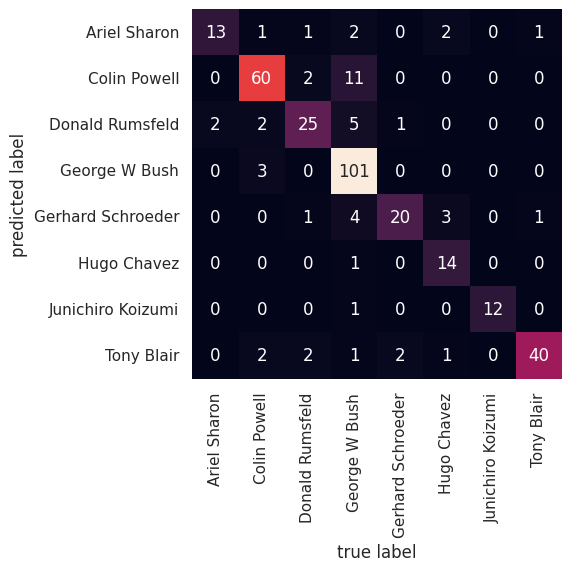

In [79]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Главная диагональ - верные классификации, а все вне этой диагонали разнородные ошибки (как оценки модели принимают один тип объектов за другой)

### **Задание 6**

 6.1. Для примера с распознаванием лиц, проверьте с помощью сеточного поиска другие гиперпараметры (svc__C - жесткость зазора,
svc__gamma, тип ядра, параметры критерия останова и т.д.)

 6.2. Оценить время поиска и качество результат

 6.3. Используйте PCA с n_components из списка (10, 50, 100, 200, 500) для подготовки данных и постройте 5 моделей с одинаковым набором гиперпараметров

 6.4 оценить результаты , сделать выводы


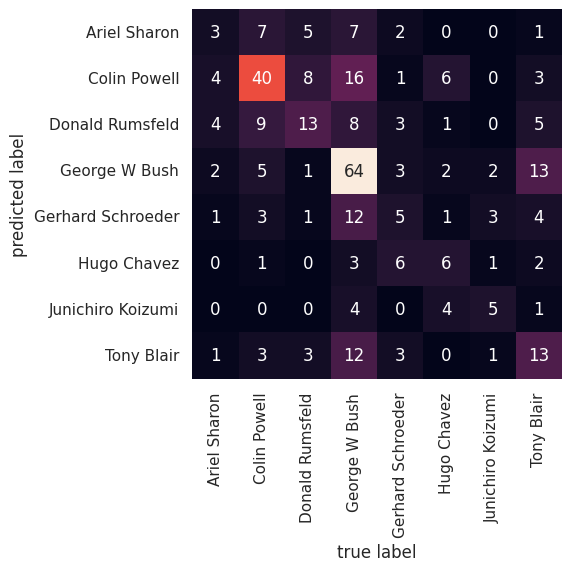

                   precision    recall  f1-score   support

     Ariel Sharon       0.12      0.20      0.15        15
     Colin Powell       0.51      0.59      0.55        68
  Donald Rumsfeld       0.30      0.42      0.35        31
    George W Bush       0.70      0.51      0.59       126
Gerhard Schroeder       0.17      0.22      0.19        23
      Hugo Chavez       0.32      0.30      0.31        20
Junichiro Koizumi       0.36      0.42      0.38        12
       Tony Blair       0.36      0.31      0.33        42

         accuracy                           0.44       337
        macro avg       0.35      0.37      0.36       337
     weighted avg       0.48      0.44      0.46       337



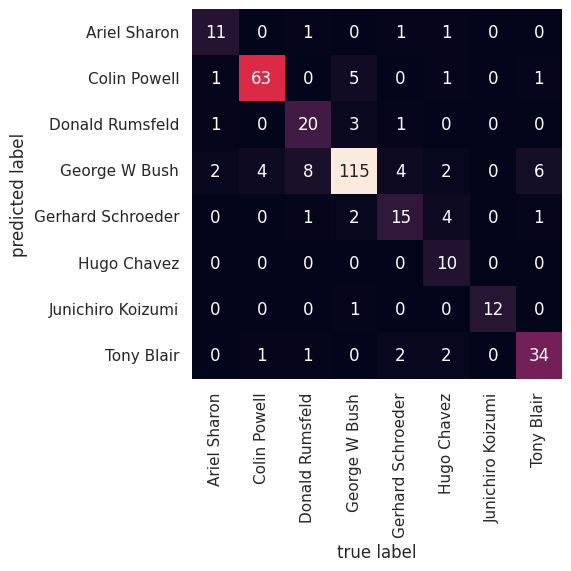

                   precision    recall  f1-score   support

     Ariel Sharon       0.79      0.73      0.76        15
     Colin Powell       0.89      0.93      0.91        68
  Donald Rumsfeld       0.80      0.65      0.71        31
    George W Bush       0.82      0.91      0.86       126
Gerhard Schroeder       0.65      0.65      0.65        23
      Hugo Chavez       1.00      0.50      0.67        20
Junichiro Koizumi       0.92      1.00      0.96        12
       Tony Blair       0.85      0.81      0.83        42

         accuracy                           0.83       337
        macro avg       0.84      0.77      0.79       337
     weighted avg       0.84      0.83      0.83       337



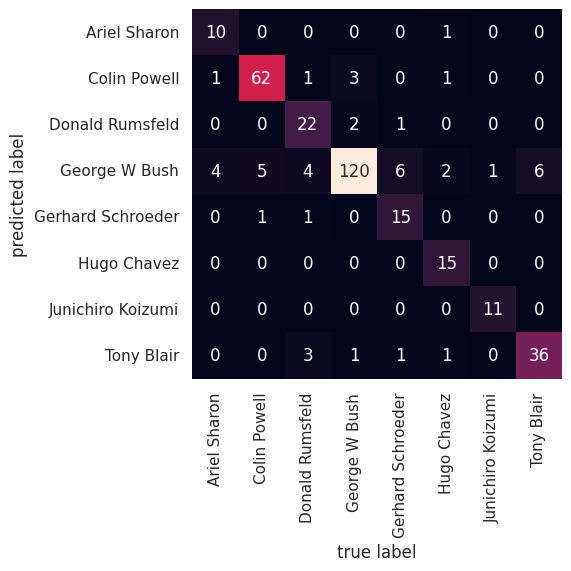

                   precision    recall  f1-score   support

     Ariel Sharon       0.91      0.67      0.77        15
     Colin Powell       0.91      0.91      0.91        68
  Donald Rumsfeld       0.88      0.71      0.79        31
    George W Bush       0.81      0.95      0.88       126
Gerhard Schroeder       0.88      0.65      0.75        23
      Hugo Chavez       1.00      0.75      0.86        20
Junichiro Koizumi       1.00      0.92      0.96        12
       Tony Blair       0.86      0.86      0.86        42

         accuracy                           0.86       337
        macro avg       0.91      0.80      0.85       337
     weighted avg       0.87      0.86      0.86       337



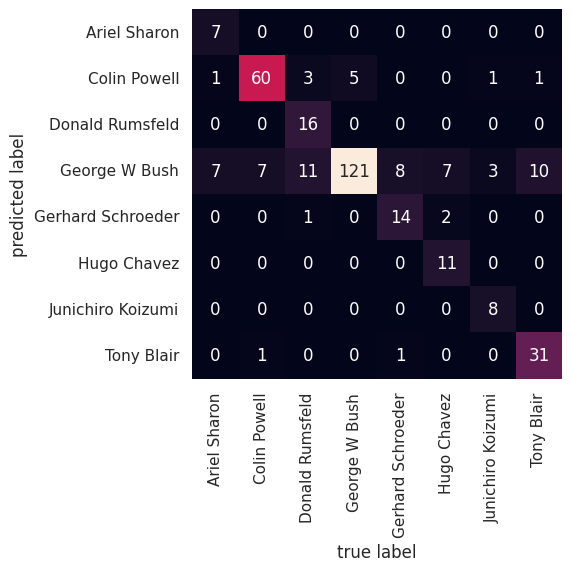

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.47      0.64        15
     Colin Powell       0.85      0.88      0.86        68
  Donald Rumsfeld       1.00      0.52      0.68        31
    George W Bush       0.70      0.96      0.81       126
Gerhard Schroeder       0.82      0.61      0.70        23
      Hugo Chavez       1.00      0.55      0.71        20
Junichiro Koizumi       1.00      0.67      0.80        12
       Tony Blair       0.94      0.74      0.83        42

         accuracy                           0.80       337
        macro avg       0.91      0.67      0.75       337
     weighted avg       0.84      0.80      0.79       337



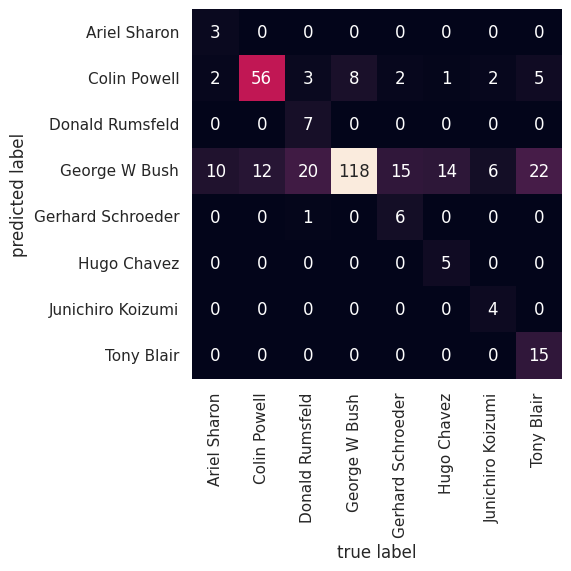

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.20      0.33        15
     Colin Powell       0.71      0.82      0.76        68
  Donald Rumsfeld       1.00      0.23      0.37        31
    George W Bush       0.54      0.94      0.69       126
Gerhard Schroeder       0.86      0.26      0.40        23
      Hugo Chavez       1.00      0.25      0.40        20
Junichiro Koizumi       1.00      0.33      0.50        12
       Tony Blair       1.00      0.36      0.53        42

         accuracy                           0.64       337
        macro avg       0.89      0.42      0.50       337
     weighted avg       0.76      0.64      0.59       337



In [72]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline # сборка конвейера обработки.

for n_component in [10, 50, 100, 200, 500]:
  # сделаем преобразование
  pca = PCA(n_components=n_component, whiten=True, random_state=None)
  svc = SVC(kernel='rbf', class_weight=dict_class) ## подставить параметры модели из сеточного поиска
  model = make_pipeline(pca, svc) # сборка конвейера обработки. не обучен, но уже собран в один объект и преобразование данных и классификатор
  model.fit(Xtrain, ytrain)
  yfit = model.predict(Xtest)
  mat = confusion_matrix(ytest, yfit)
  sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
              xticklabels=faces.target_names,
              yticklabels=faces.target_names)
  plt.xlabel('true label')
  plt.ylabel('predicted label')
  plt.show()
  print(classification_report(ytest, yfit,
                            target_names=faces.target_names))


Вопросы для контроля:

  1. Перечислить особенности метода опорных векторов: потери, целевая функция.
  2. какой тип оптимизации используется?
  3. Обоснование метода опорных векторов и основная идея.
  4. Сформулируйте ограничения теоремы Куно-Такера.
  5. Можно ли в рамках метода опорных векторов решать задачи для линейно не разделимых множеств, как это описать формально?
  6. В каких вариантах данных необходимо использовать ядера в SVM?
  7. Как решить задачу в многоклассовой постановке?